<a href="https://colab.research.google.com/github/econ105/AI/blob/main/Python/Algotrading/HSI_ARIMA_(Autoregressive_Integrated_Moving_Average).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mplfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mplfinance as mpf

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [5]:
# Load data
df = pd.read_csv('HSI_15.csv', parse_dates=['time'], date_format={'time': '%Y-%m-%dT%h:%m:%s'})
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df = df.asfreq('15min')


In [6]:
# Calculate 180-period EMA
df['EMA_60'] = df['close'].ewm(span=60, adjust=False).mean()

In [7]:
# Detrend the data by subtracting EMA_60
df['Detrended'] = df['close'] - df['EMA_60']

In [8]:
train = df.loc[df.index<'2024-01-01']
test = df.loc[df.index>= '2024-01-01']
train=train.dropna()
test=test.dropna()
train = train.asfreq('15min')
test=test.asfreq('15min')


In [9]:
# Fit ARIMA model on training detrended data
model = ARIMA(train['Detrended'], order=(2, 1, 1))
model_fit = model.fit()

In [10]:
summary = model_fit.summary()
print(summary)

                               SARIMAX Results                                
Dep. Variable:              Detrended   No. Observations:                78364
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -72081.703
Date:                Sun, 15 Feb 2026   AIC                         144171.405
Time:                        03:58:55   BIC                         144208.482
Sample:                    10-04-2021   HQIC                        144182.782
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9378      0.006    166.562      0.000       0.927       0.949
ar.L2          0.0363      0.006      6.364      0.000       0.025       0.048
ma.L1         -1.0000      0.000  -8763.977      0.0

In [11]:
# Forecast for testing period
forecast_detrended = model_fit.forecast(steps=len(test))
print(forecast_detrended)

2023-12-29 16:20:00    98.973323
2023-12-29 16:35:00    96.553251
2023-12-29 16:50:00    94.157900
2023-12-29 17:05:00    91.823591
2023-12-29 17:20:00    89.547427
                         ...    
2025-01-09 16:35:00     0.521468
2025-01-09 16:50:00     0.521468
2025-01-09 17:05:00     0.521468
2025-01-09 17:20:00     0.521468
2025-01-09 17:35:00     0.521468
Freq: 15min, Name: predicted_mean, Length: 36198, dtype: float64


In [12]:
# Add back EMA to reconstruct forecasted values
test['forecast_reconstructed'] = forecast_detrended + test['EMA_60']

test=test.dropna()
test

,open,high,low,close,EMA_60,Detrended,forecast_reconstructed
time,,,,,,,
2024-01-02 09:20:00,17135.12,17135.12,16976.82,16976.82,16976.813411,0.006589,16977.347185
2024-01-02 09:35:00,16978.31,16979.48,16897.39,16903.02,16974.393955,-71.373955,16974.927422
2024-01-02 09:50:00,16904.21,16916.32,16849.35,16879.98,16971.298416,-91.318416,16971.831584
2024-01-02 10:05:00,16881.34,16898.39,16856.10,16856.34,16967.529287,-111.189287,16968.062164
2024-01-02 10:20:00,16856.83,16856.83,16791.69,16810.40,16962.377507,-151.977507,16962.910099
...,...,...,...,...,...,...,...
2025-01-09 15:05:00,19283.11,19284.45,19250.62,19251.54,19316.998598,-65.458598,19317.520066
2025-01-09 15:20:00,19255.04,19263.70,19250.32,19252.68,19314.889791,-62.209791,19315.411259
2025-01-09 15:35:00,19253.49,19263.14,19247.83,19260.16,19313.095372,-52.935372,19313.616840


In [13]:
test.index.dtype

dtype('<M8[ns]')

In [14]:
# Calculate RMSE for evaluation
rmse = np.sqrt(mean_squared_error(test['close'], test['forecast_reconstructed']))
print(f"RMSE: {rmse:.2f}")

RMSE: 176.70


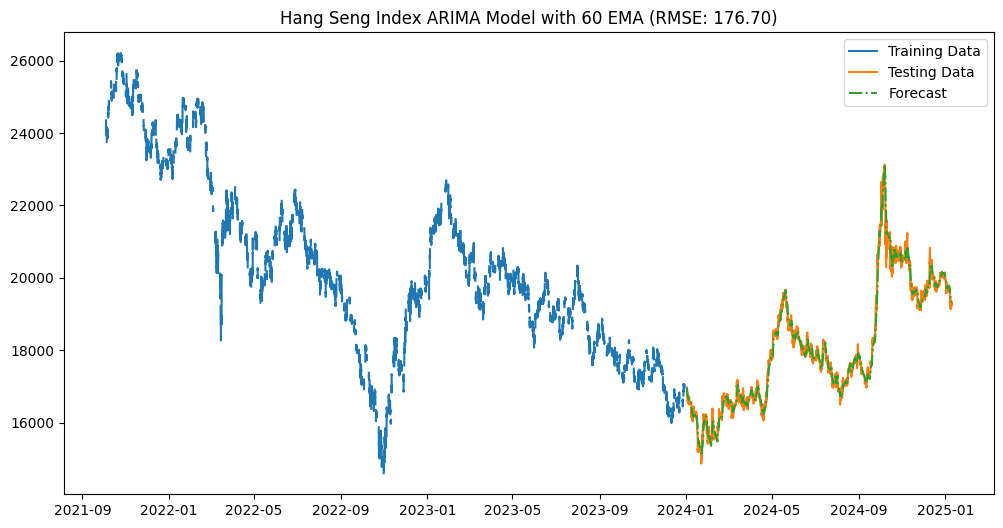

In [15]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['close'], label='Training Data')
plt.plot(test['close'], label='Testing Data')
plt.plot(test['forecast_reconstructed'], label='Forecast', linestyle='-.')
plt.legend()
plt.title(f'Hang Seng Index ARIMA Model with 60 EMA (RMSE: {rmse:.2f})')
plt.show()

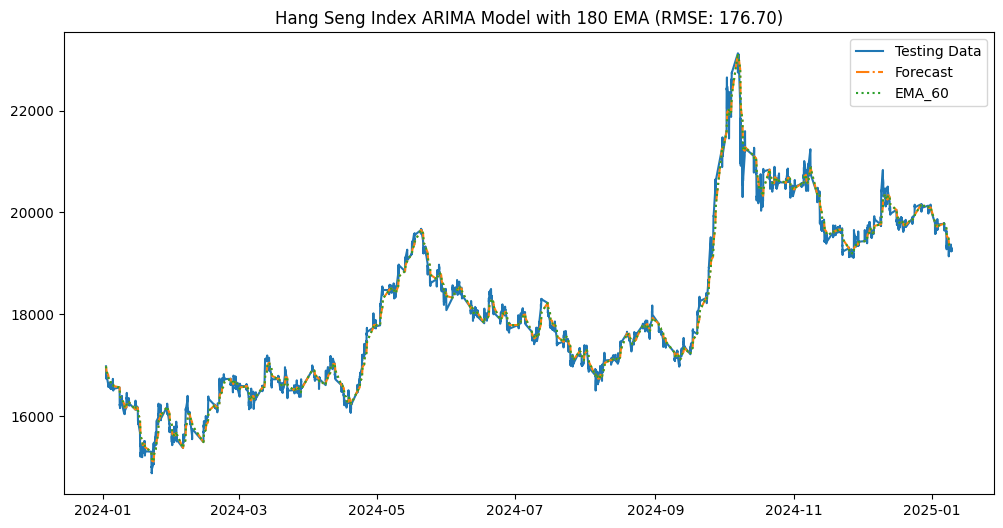

In [16]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test['close'], label='Testing Data')
plt.plot(test['forecast_reconstructed'], label='Forecast', linestyle='-.')
plt.plot(test['EMA_60'], label='EMA_60',linestyle=':')
plt.legend()
plt.title(f'Hang Seng Index ARIMA Model with 180 EMA (RMSE: {rmse:.2f})')
plt.show()

In [17]:
###Back testing#### trading strategy

In [18]:
class TradingStrategy:
    def __init__(self):
        self.positions = []
        self.returns = []
        self.daily_returns = None
        self.entry_price = None
        self.stop_loss = None
        self.take_profit = None

    def generate_signals(self, actual_prices, predicted_prices, df=None):
        """Generate trading signals based on MA crossovers, MACD, and weekly ranges"""
        signals = []
        self.positions = [0]  # Initialize with neutral position
        position = 0  # 0 for neutral, 1 for long only
        self.entry_price = None

        # Get weekly ranges and technical indicators
        weekly_ranges = df['Weekly_Range'].iloc[len(df)-len(actual_prices):]
        ma_20 = df['MA_20'].iloc[len(df)-len(actual_prices):]
        ma_60 = df['MA_60'].iloc[len(df)-len(actual_prices):]
        macd = df['MACD'].iloc[len(df)-len(actual_prices):]
        macd_signal = df['MACD_Signal'].iloc[len(df)-len(actual_prices):]
        rsi = df['RSI'].iloc[len(df)-len(actual_prices):]

        for i in range(1, len(predicted_prices)):
            current_price = actual_prices[i][0]
            pred_price = predicted_prices[i][0]
            weekly_range = weekly_ranges.iloc[i]

            # If we have an open position, check for exit conditions
            if position == 1 and self.entry_price is not None:
                # Check if stop loss is hit
                if current_price <= self.stop_loss:
                    position = 0
                    signals.append(('STOP_LOSS', i, current_price))
                    self.entry_price = None
                    self.stop_loss = None
                    self.take_profit = None
                    continue

                # Check if take profit is hit
                if current_price >= self.take_profit:
                    position = 0
                    signals.append(('TAKE_PROFIT', i, current_price))
                    self.entry_price = None
                    self.stop_loss = None
                    self.take_profit = None
                    continue

            # Entry conditions (Buy Only):
            # 1. Strong uptrend (MA20 significantly above MA60)
            # 2. Strong momentum (MACD positive and increasing)
            # 3. RSI not overbought (< 70)
            # 4. Predicted price shows potential upside
            if position == 0:
                strong_trend = (ma_20.iloc[i] > ma_60.iloc[i] and
                              (ma_20.iloc[i] - ma_60.iloc[i]) > weekly_range * 0.1)

                macd_strength = macd.iloc[i] - macd_signal.iloc[i]
                strong_momentum = macd_strength > 0 and macd_strength > macd.iloc[i-1] - macd_signal.iloc[i-1]

                not_overbought = rsi.iloc[i] < 70
                price_prediction = pred_price > current_price * 1.001  # Minimum 0.1% predicted increase

                if strong_trend and strong_momentum and not_overbought and price_prediction:
                    position = 1
                    self.entry_price = current_price

                    # Set stop loss at 1/3 of weekly range below entry
                    stop_distance = weekly_range * 0.33
                    self.stop_loss = self.entry_price - stop_distance

                    # Set take profit at 3x the stop loss distance (3:1 ratio)
                    self.take_profit = self.entry_price + (stop_distance * 3)

                    signals.append(('BUY', i, current_price))

            self.positions.append(position)

        return signals

    def calculate_returns(self, prices):
        """Calculate strategy returns and performance metrics"""
        if len(self.positions) != len(prices):
            self.positions = self.positions[:len(prices)]
            while len(self.positions) < len(prices):
                self.positions.append(self.positions[-1])

        positions = np.array(self.positions)
        daily_returns = np.diff(prices.flatten()) / prices[:-1].flatten()
        self.daily_returns = daily_returns
        strategy_returns = positions[:-1] * daily_returns

        # Calculate performance metrics
        cumulative_returns = np.cumprod(1 + strategy_returns) - 1
        sharpe_ratio = np.sqrt(252) * np.mean(strategy_returns) / np.std(strategy_returns)
        max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

        # Risk metrics
        var_95 = np.percentile(strategy_returns, 5)
        var_99 = np.percentile(strategy_returns, 1)
        es_95 = np.mean(strategy_returns[strategy_returns <= var_95])
        prob_profit = np.mean(strategy_returns > 0)

        return {
            'cumulative_returns': cumulative_returns,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_return': cumulative_returns[-1],
            'var_95': var_95,
            'var_99': var_99,
            'es_95': es_95,
            'prob_profit': prob_profit,
            'strategy_returns': strategy_returns
        }